# **INF8250AE Projet : Transfer Learning in Reinforcement Learning**

Ce projet entre dans le cadre du cours INF8250AE - Reinforcement Learning à Polytechnique Montreal.

**Students:**
* Antoine Leblanc (2310186) - antoine.leblanc@polymtl.ca
* Maxime Montois (2306823) - maxime.montois@polymtl.ca
* Hugo Petrilli (2306643) - hugo-cedric.petrilli@polymtl.ca

## **I - Introduction**

Le **transfert d'apprentissage ou "transfert learning" (TL)** est une méthode de Machine Learning qui consiste à utiliser les connaissances d'un modèle existant pour entrainer un nouveau modèle sur la réalisation de tâches assez à celles pour lesquelles le premier modèle a été entraîné.

Intuitivement, lorsque nous souhaitons entrainer deux modèles sur deux tâches similaires, il serait long et non optimal d'entraîner les deux modèles séparémment en partant de zéro. Il serait plus rapide d'entraîner un premier modèle, et d'utiliser les apprentissages du premier modèle pour permettre au deuxième modèle d'apprendre plus vite. C'est exactement ce que fait le transfert learning.

**Motivations**

Le tranfert learning est une méthode qui a fait ses preuves et qui est beaucoup utilisée dans le traitement de langage naturel (NLP) pour faire de la traduction ou de l'analyse de sentiment, ou encore en reconnaissance d'image notamment dans le secteur de la santé et de la biologie où il permet la détection de maladies. Si le transfert learning est si efficace dans ces secteurs, c'est que les tâches demandées sont assez similaires puisque les images des maladies peuvent se ressembler et qu'il est donc assez naturel d'entrainer un modèle général servant de base à des modèles de détection de maladies plus spécifiques. La deuxième raison qui justifie son succès est qu'il est assez facile de mettre en place le transfert learning dans le cas de l'apprentissage supervisé puisqu'il suffit de transmettre le modèle permettant d'effectuer les prédictions.

En revanche, lorsque l'apprentissage n'est pas supervisé, et en particulier dans le cas du reinforcement learning, il est beaucoup plus compliqué d'effectuer le transfert learning. En effet, comme nous n'avons pas connaissance de l'environnement dans lequel se trouve le modèle, pour trouver la solution, en reinforcement learning, il est nécessaire d'explorer différentes possibilités, tout en essayant d'indentifier et de faire le plus souvent possible les meilleurs choix. Ces deux envies d'explorer l'environnement pour trouver de meilleures solutions et de choisir les meilleurs solutions déjà trouvées sont en oposition et constituent le dilemme exploration-exploitation. C'est ce qui fait la complexité des modèles de reinforcement learning et c'est également ce qui fait qu'il est difficile de trouver une manière simple d'effectuer le transfert learning.

**Problématique**

Aussi, il n'y a pas de modèle pour prédire le résultat à transférer, alors que faut-il transmettre? Les paramètres, les fonctions de valeurs, ou plutôt les politiques? De plus, les agents entre deux modèles même similaires peuvent avoir des actions et des états différents, ce qui rend leur structure différente. Ainsi, il n'est pas toujours possible de simplement transférer le modèle. Pourtant, même en reinforcement learning, il y a bien des informations qui pourraient se transmettre d'un agent à un autre afin d'améliorer l'efficacité et la rapidité d'apprentissage des agents. Nous avons donc décidé d'étudier le transfert learning en reinforcement learning pour voir comment effectuer le transfert learning et mesurer son efficacité.

**Plan**

Dans cette introduction au Transfer Learning pour le Reinforcement Learning, nous débutons en définissant deux environnements CarPole distincts dans le but est d'explorer les méthodes de Transfer Learning. Nous choisissons d'utiliser deux agents déjà abordés en cours, à savoir le DQN (Deep Q-Network) et le REINFORCE, pour l'entraînement. Ensuite, nous présentons une synthèse des approches et des modèles examinés dans les divers articles référencés dans le cadre de ce projet. Enfin, nous concluons ce projet par un exemple concret illustrant l'application de la méthode de transfert de politique.

## **II - Environnement CartPole**

Tout au long de ce projet, les différents concepts exposé seront illustré grâce à l'environnement [`CartPole-v1`](https://gymnasium.farama.org/environments/classic_control/cart_pole/) d'OpenAI Gymnasium déjà étudié lors de l'assignment 4 du cours. Dans cet environnement, le but est d'équilibrer un pendule inversé sur un chariot en déplaçant latéralement le chariot. L'état de l'agent comporte quatre composantes :

- La position horizontale du chariot, $x$
- La vitesse du chariot, $\dot{x}$
- L'angle du pendule, mesuré par rapport à l'axe vertical, $\theta$
- La vitesse angulaire du pendule, $\dot\theta$

Il y a deux actions dans l'espace d'action :
- 0 : pousser le chariot vers la gauche
- 1 : pousser le chariot vers la droite

L'agent reçoit une récompense de $1$ à chaque pas de temps, et l'épisode se termine lorsque le pendule descend trop loin ($|\theta|$ est supérieur à $12^o$) ou lorsque le chariot sort des limites ($|x|$ supérieur à $2.4$). De plus, l'environnement est tronqué après $500$ étapes s'il n'est pas déjà terminé, le rendement le plus élevé possible est donc de $500$.

### **II.1 - Installation et Importation des packages**

In [ ]:
!pip install -U pygame
!pip install gymnasium
!pip install matplotlib
!pip install tqdm
!apt-get install x11-utils > /dev/null 2>&1
!pip install pyglet > /dev/null 2>&1
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install pyvirtualdisplay > /dev/null 2>&1
!pip install pillow

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch
import torch.distributions as torchdist
import torch.nn as nn
import torch.nn.functional as F
import warnings
import functools
import random
import os
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
import sys
import copy
from contextlib import closing
from io import StringIO

import gymnasium as gym
from gymnasium import utils
from gymnasium import Env, spaces
from gymnasium.utils import seeding
from tqdm import tqdm
from PIL import Image
from IPython.display import Image as IPImage, display

device = "cpu"
warnings.filterwarnings('ignore')
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

On réutilise la fonction de rendu vidéo crée dans l'assignment 4 du cours.

In [ ]:
def render_video(env, policy=None, steps=500):
    env.action_space.seed(0)
    obs, _ = env.reset(seed=0)
    rewards = []
    image_list = []
    for i in range(steps):
        if policy == None:
            action = env.action_space.sample()
        else:
            action = policy.get_action(obs, env)
        obs, reward, terminated, truncated, info = env.step(action)
        rewards.append(reward)
        screen = env.render()
        image_list.append(screen)

        done = terminated or truncated
        if done:
            print("Return: ", sum(rewards))
            break
        env.close()
    if not done:
        print("Return: ", sum(rewards))
    pil_images = [Image.fromarray(image) for image in image_list]
    pil_images[0].save(
        "output.gif", save_all=True, append_images=pil_images[1:], duration=50, loop=0
    )
    display(IPImage("output.gif"))

### **II.2 - Création des environnements CartPole**

Afin d'évaluer les méthodes mises en place, on crée deux environnements CartPole ayant des paramètres différents `cartPoleDefault` et `cartPoleModified`.

| **Variables**        | gravity | masscart | masspole | length |
|:---------------------:|:-------:|:--------:|:--------:|:------:|
| `cartPoleDefault`   |   9.8   |   1.0    |   0.1    |  0.5   |
| `cartPoleModified`  |   20.0  |   0.1    |   2.0    |  1.0   |

Libre à l'utiliseur de tester d'autres environnements.

In [ ]:
# Function to generate custom CartPole.
def create_custom_cart_pole(gravity=9.8, masscart=1.0, masspole=0.1, length=0.5):
    env = gym.make("CartPole-v1", render_mode="rgb_array", max_episode_steps=500)
    env.env.env.env.gravity = gravity
    env.env.env.env.masscart = masscart
    env.env.env.env.masspole = masspole
    env.env.env.env.total_mass = masscart + masspole
    env.env.env.env.length = length
    env.env.env.env.polemass_length = masspole * length
    return env

In [ ]:
# Default CartPole
cartPoleDefault = create_custom_cart_pole()

In [ ]:
# Modified CartPole
cartPoleModified = create_custom_cart_pole(gravity=20.0, masscart=0.1, masspole=2.0, length=1.0)

On visualise les environnements pour des politiques aléatoires afin d'observer leur différences.

Return:  18.0


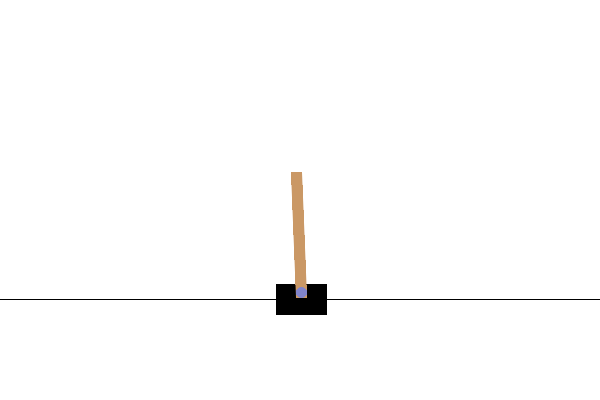

In [ ]:
render_video(cartPoleDefault)

Return:  14.0


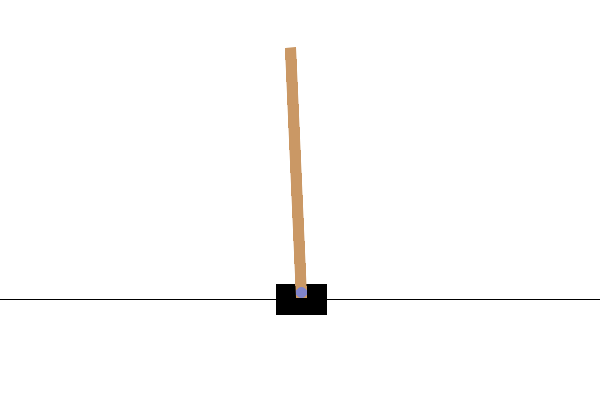

In [ ]:
render_video(cartPoleModified)

## **III - Agents**

Pour évaluer les diverses approches du Transfer Learning dans le contexte du Reinforcement Learning, nous identifions deux agents spécifiques : le Deep Q-Network et le REINFORCE avec baseline. Nous examinerons comment ces méthodes sont influencées et dans quelle mesure elles sont efficaces en fonction des techniques de Transfer Learning.

### **III.1 - Fonctions utiles**

#### **III.1.1 - Fonctions utiles pour DQN**

On définit une fonction ReplayBuffer, permettant de revoir des exemples pour entraîner DQN, comme déjà vu dans les assignments du cours.

In [ ]:
class ReplayBuffer:
    """This class implements a replay buffer for experience replay for DQN."""
    def __init__(self, buffer_size, observation_space, action_space):
        self.buffer_size = buffer_size
        self.observations = np.zeros(
            (buffer_size,) + observation_space.shape, dtype=observation_space.dtype
        )
        self.next_observations = np.zeros(
            (buffer_size,) + observation_space.shape, dtype=observation_space.dtype
        )
        self.actions = np.zeros(
            (buffer_size,) + action_space.shape, dtype=action_space.dtype
        )
        self.rewards = np.zeros((buffer_size,), dtype=np.float32)
        self.terminated = np.zeros((buffer_size,), dtype=np.uint8)
        self.position = 0
        self.num_added = 0

    def add(self, observation, action, reward, next_observation, terminated):
        """
        Adds a new experience tuple to the replay buffer.

        Parameters:
            - observation (np.ndarray): The current observation.
            - action (int): The action taken.
            - reward (float): The reward received.
            - next_observation (np.ndarray): The next observation.
            - terminated (bool): Whether the episode terminated after this experience.

        Returns:
            - None
        """
        self.observations[self.position] = observation
        self.next_observations[self.position] = next_observation
        self.actions[self.position] = action
        self.rewards[self.position] = reward
        self.terminated[self.position] = terminated
        self.position = (self.position + 1) % self.buffer_size
        self.num_added += 1

    def sample(self, batch_size):
        """
        Samples a batch of experiences from the replay buffer.

        Parameters:
            - batch_size (int): The number of experiences to sample.

        Returns:
            - observations (np.ndarray): The current observations. Shape (batch_size,
              observation_dim)
            - actions (np.ndarray): The actions taken. Shape (batch_size, action_dim)
            - rewards (np.ndarray): The rewards received. Shape (batch_size,)
            - next_observations (np.ndarray): The next observations. Shape (batch_size,
              observation_dim)
            - terminated (np.ndarray): Whether the episode terminated after this
              experience.
        """
        buffer_size = min(self.num_added, self.buffer_size)
        indices = np.random.randint(0, buffer_size, size=batch_size)
        return (
            self.observations[indices],
            self.actions[indices],
            self.rewards[indices],
            self.next_observations[indices],
            self.terminated[indices],
        )

On définit une fonction pour effectuer un entrainement pour DQN.

In [ ]:
def training_DQN(agent, env, NUM_STEPS=100000, LOG_FREQUENCY=2000):
  episode_rewards = []
  losses = []
  vals = []
  episode_reward = 0
  episode_reward_mean = []
  state, _ = env.reset()
  for step in tqdm(range(NUM_STEPS)):
      action = agent.get_action(state,env)
      next_state, reward, terminated, truncated, _ = env.step(action)
      episode_reward += reward
      metrics = agent.update(
          {
              "observation": state,
              "action": action,
              "reward": reward,
              "next_observation": next_state,
              "terminated": terminated,
              "truncated": truncated,
          },
          step,
      )
      state = next_state
      if terminated or truncated:
          episode_rewards.append(episode_reward)
          episode_reward = 0
          episode_length = 0
          state, _ = env.reset()
      if step % LOG_FREQUENCY == 0:
          if 'loss' in metrics:
            losses.append(metrics["loss"])
            vals.append(metrics["values"])
          episode_reward_mean.append(np.mean(episode_rewards[-10:]))
          # print("Step: {0}, Average Return: {1:.2f}".format(step, np.mean(episode_rewards[-10:])))

  return episode_reward_mean, losses, vals

#### **III.1.2 - Fonctions utiles pour REINFORCE avec baseline**

On définit une fonction pour générer un épisode pour entraîner Reinforce.

In [ ]:
def generate_episode(env: gym.Env, policy):
    """
    Generates an episode given an environment and policy
    Inputs:
        env - Gymnasium environment
        policy - policy for generating episode
    Returns

    """
    # Initialize lists
    states = []
    actions = []
    rewards = []
    terminated = []
    truncated = []

    # Reset environment
    state, _ = env.reset(seed=0)
    done = False

    # Loop until end of episode
    while not done:
        states.append(state)
        # Get action
        action = policy.get_action(state, env)
        actions.append(action)
        # Take step
        state, reward, term, trunc, _ = env.step(action)
        done = term or trunc
        rewards.append(reward)
        terminated.append(term)
        truncated.append(trunc)
    states = np.array(states)
    actions = np.array(actions)
    rewards = np.array(rewards)
    terminated = np.array(terminated)
    truncated = np.array(truncated)
    return (states, actions, rewards, terminated, truncated)

On définit une fonction pour initialiser le réseau de neurones pour l'approximation de la fonction valeurs détats.

In [ ]:
def value_init_network(env: gym.Env) -> nn.Module:
    model = nn.Sequential(
        nn.Linear(env.observation_space.shape[0],32),
        nn.ReLU(),
        nn.Linear(32,32),
        nn.ReLU(),
        nn.Linear(32,1)
    )
    return(model)

On définit une fonction pour initialiser le réseau de neurones pour l'approximation de la politique.

In [ ]:
def policy_init_network(env: gym.Env) -> nn.Module:
    dim_of_state = env.observation_space.shape[0]
    dim_of_action = env.action_space.n
    model = nn.Sequential(
        nn.Linear(dim_of_state,32),
        nn.ReLU(),
        nn.Linear(32,32),
        nn.ReLU(),
        nn.Linear(32,dim_of_action),
        nn.Softmax()
    )
    return model

Une fonction pour construire $G_t$ afin d'entraîner Reinforce avec baseline. On le rappelle, la mise à jour des paramètres se fait à l'aide de $\nabla_\theta J(\theta)$:
$$
\nabla_\theta J(\theta) = \sum_{k=0}^T\mathbf{E}\left\{(G^{\pi_\theta} - b(s_k))\nabla_\theta\log\pi_\theta(a_k\mid s_k)\right\}
$$

In [ ]:
def discounted_returns(
    rewards: np.ndarray, dones: np.ndarray, discount: float
) -> np.ndarray:
    """
    Compute discounted returns given rewards and terminateds
    Inputs:
        rewards - numpy array of reward values
        dones - numpy array consisting of boolean values for whether the episode has terminated.
        discount - discount factor
    Returns:
        returns - numpy array discounted returns
    """
    T = rewards.shape[0]
    returns = [0]*T
    g = 0
    for k in range(T-1,-1,-1):
      if dones[k] : # Si c'est l'épisode est truncated ou terminated
        returns[k] = rewards[k]
      else :
        returns[k] = returns[k+1] * discount + rewards[k]
    return np.array(returns)

Fonction pour entraîner Reinforce.

In [ ]:
def training_REINFORCE(agent, env, gradient_steps=500, test_runs=5):

  scores = np.zeros(gradient_steps)
  stds = np.zeros(gradient_steps)

  def rollout_score(env, policy):
      _, _, rewards, _, _ = generate_episode(env, policy)
      return np.sum(rewards)


  gs = list(range(gradient_steps))

  value_losses = []

  print(f"Training {agent.name}")
  losses = []
  for g in tqdm(range(gradient_steps)):
      states, actions, rewards, terminated, truncated = generate_episode(
          env, agent
      )
      dones = [term or trunc for (term, trunc) in zip(terminated, truncated)]
      loss = agent.update(states, actions, rewards, dones)
      losses.append(loss["policy_loss"])
      if "value_loss" in loss.keys():
          value_losses.append(loss["value_loss"])
      res = [rollout_score(env, agent) for _ in range(test_runs)]
      scores[g] = np.mean(res)
      stds[g] = np.std(res)

  return(scores, losses, stds)

#### **III.1.3 Fonctions utiles globales**

On définit une fonction pour évaluer un agent.

In [ ]:
def evaluate_agent(agent, env, num_episodes):
    """ Collect num_episodes trajectories for the agent and compute mean and std of the
    rewards. Remember to reset the environment before each episode.
    Args:
        agent: Agent, agent to evaluate
        env: gym.Env, environment to evaluate agent on
        num_episodes: int, number of episodes to evaluate the agent for
    Returns:
        mean_return: float, mean return over the episodes
        std_return: float, standard deviation of the return over the episodes
    """
    returns = []
    for i in tqdm(range(num_episodes)):
      obs, _ = env.reset()
      terminated = False
      truncated = False
      rewards = 0
      while not (terminated or truncated):
        action = agent.get_action(obs, env)
        obs,reward,terminated,truncated,_ = env.step(action)
        rewards += reward
      returns.append(rewards)
    returns = np.array(returns)
    mean_return = np.mean(returns)
    std_return = np.std(returns)
    return mean_return, std_return

### **III.2 - Deep Q-Network (DQN)**



On définit l'agent Deep Q-Network (DQN).

In [ ]:
class DQN():
  def __init__(
        self,
        observation_space,
        action_space,
        epsilon = .1,
        learning_starts_at = 500,
        learning_frequency = 10,
        learning_rate = .001,
        discount_factor = .99,
        buffer_size = 1000,
        target_update_frequency = 100,
        batch_size = 128,
    ):
        self.observation_space = observation_space
        self.action_space = action_space
        self.network = self.build_network(observation_space, action_space)
        self.target_network = copy.deepcopy(self.network).requires_grad_(False)

        self.replay_buffer = ReplayBuffer(
            buffer_size=buffer_size,
            observation_space=observation_space,
            action_space=action_space,
        )
        self.epsilon = epsilon
        self.learning_starts_at = learning_starts_at
        self.learning_frequency = learning_frequency
        self.discount_factor = discount_factor
        self.optimizer = torch.optim.Adam(self.network.parameters(), lr=learning_rate)
        self.loss_fn = torch.nn.MSELoss()
        self.target_update_frequency = target_update_frequency
        self.batch_size = batch_size

  def build_network(self, observation_space, action_space):
        """
        Builds a neural network that maps observations to Q-values for each action.
        """
        input_dimension = observation_space.shape[0]
        output_dimension = action_space.n
        return torch.nn.Sequential(
            torch.nn.Linear(input_dimension, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, output_dimension),
        )

  def get_action(self, state, env):
        """Implements epsilon greedy policy. With probability epsilon, take a random
        action. Otherwise, take the action that has the highest Q-value for the
        current state. For sampling a random action from the action space, take a look
        at the API for spaces: https://gymnasium.farama.org/api/spaces/#the-base-class.
        Do not hardcode the number of actions you are sampling from.

        Parameters:
            - state (np.ndarray): The current state.

        Returns:
            - action (int): The action to take.
        """
        if np.random.rand() < self.epsilon :
          action = self.action_space.sample()
          return int(action)
        else :
          state = torch.tensor(state)
          q_values = self.network(state)
          indices_max = (q_values == q_values.max()).nonzero()  # On récupère tous les indices maximaux
          random_max_index = random.choice(indices_max).item() # On choisit de manièe aléatoire un indice
          return random_max_index

  def update(self, experience, step):
        """
        Adds the experience to the replay buffer and performs a training step.

        Parameters:
            - experience (dict): A dictionary containing the keys "observation",
              "action", "reward", "next_observation", "terminated", and "truncated".
        """
        self.replay_buffer.add(
            experience["observation"],
            experience["action"],
            experience["reward"],
            experience["next_observation"],
            experience["terminated"],
        )
        metrics = {}
        if step > self.learning_starts_at and step % self.learning_frequency == 0:
            metrics = self.perform_training_step()


        if step % self.target_update_frequency == 0:
            self.target_network.load_state_dict(self.network.state_dict())
        return metrics

  def perform_training_step(self):
        (
            observations,
            actions,
            rewards,
            next_observations,
            terminated,
        ) = self.replay_buffer.sample(self.batch_size)
        observations = torch.Tensor(observations)
        actions = torch.Tensor(actions).long()
        rewards = torch.Tensor(rewards)
        next_observations = torch.Tensor(next_observations)
        terminated = torch.Tensor(terminated)
        q_values = self.network(observations).gather(1, actions.unsqueeze(1)).squeeze()
        with torch.no_grad():
            targets = self.compute_targets(rewards, next_observations, terminated)
        loss = self.loss_fn(q_values, targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return {
            "loss": loss.item(),
            "values": q_values.mean().detach().numpy()
        }

  def compute_targets(self, rewards, next_observations, terminated):
        """
        Computes the target Q-values for a batch of transitions. Make sure to use the
        target network for this computation. If the episode terminated, the target
        Q-value should be the reward, otherwise the reward plus the discounted
        maximum target Q-value for the next state.

        In order to do this efficiently, you should not use a for loop or any if
        statements, but instead use tensor operations and the fact that (1 - terminated)
        will be 0 for all the terminal transitions.

        Parameters:
            - rewards (torch.Tensor): The rewards received for each transition in the
                batch. Shape (batch_size,)
            - next_observations (torch.Tensor): The next observations for each
                transition in the batch. Shape (batch_size, observation_dim)
            - terminated (torch.Tensor): Whether the episode terminated after each
                transition in the batch. Shape (batch_size,)
        Returns:
            - targets (torch.Tensor): The targets for each transition in the batch.
                Shape (batch_size,)
        """
        q_values = self.target_network(next_observations)
        max_q_values,_ = torch.max(q_values, dim=1)
        targets = rewards + self.discount_factor*(1-terminated)*max_q_values
        return(targets)

### **III.3 - REINFORCE avec baseline**

On définit l'agent REINFORCE avec baseline (REINFORCEWithBaselinePolicy).

In [ ]:
class REINFORCEWithBaselinePolicy():

    def __init__(
        self, env: gym.Env, policy_network: nn.Module, value_network: nn.Module, discount=0.99, name="REINFORCE with Baseline"
    ):
        self.name = name
        self.network = policy_network
        self.discount = discount

        self.env = env
        self.obs_dim = env.observation_space.shape[0]
        self.n_actions = env.action_space.n
        params = self.network.parameters()
        self.opt = torch.optim.Adam(params,lr=1e-3)

        self.value_network = value_network
        value_params = self.value_network.parameters()
        self.value_opt = torch.optim.Adam(value_params,lr=0.002)

    def distribution(self, x: np.ndarray) -> torchdist.distribution.Distribution:
        """
        Get the distribution over actions for a given state. The distribution parameters
        come from the network, which should output the unnormalized probabilities of
        each action. (Note, this is not the same as unnormalized log probabilities).
        """
        state = torch.tensor(x, dtype=torch.float32)
        probs = self.network(state)
        probs = probs.view(-1, self.n_actions)
        dist = torchdist.categorical.Categorical(probs)
        return dist

    def get_action(self, x: np.ndarray, env) -> int:
        """
        Sample an action from the policy at a given state

        Input: a state encoded as a numpy array
        Output: an action encoded as an int
        """
        dist = self.distribution(x)
        action = dist.sample()
        action = action.item()
        return action

    def update(self, states, actions, rewards, dones) -> float:
        loss_dict = {}
        G = torch.tensor(discounted_returns(rewards, dones, self.discount))

        # On choisit l'action et on effectue un step
        actions_tensor = torch.tensor(actions, dtype = torch.int32)
        dist = self.distribution(states)
        log_prob = dist.log_prob(actions_tensor)
        states_tensor = torch.tensor(states, dtype = torch.float32)
        value_states = self.value_network(states_tensor).squeeze()

        # On calcule l'erreur de TD
        delta = G - value_states

        # On calcule la loss de la politique
        policy_loss = - torch.mean(log_prob * delta)

        # On calcule la loss de la baseline
        value_loss = torch.mean(delta**2)

        # Calcule le gradient de la politique
        self.opt.zero_grad()
        policy_loss.backward(retain_graph=True)

        # On met à jour les paramètres de la politique
        self.opt.step()

        # On calcule le gradient de la baseline
        self.value_opt.zero_grad()
        value_loss.backward()

        # On met à jour les paramètres de la baseline
        self.value_opt.step()

        loss_dict = {"policy_loss" : policy_loss.item(), "value_loss" : value_loss.item()}

        return loss_dict

## **IV - Approches pour effectuer le transfert learning**

### **IV.1 - Formulation du problème**

En reinforcement learning, lorsque nous entrainons le modèle, nous cherchons à trouver la meilleure politique $\pi^*$ donnant pour chaque couple état/action $(s,a)$ , la probabilité de prendre l'action $a$ en étant dans l'état $s$.
En transfert learning, il faut transférer de l'information pour aider le modèle à trouver plus vite les meilleures solutions tout en garantissant quand même que le modèle pourra explorer son environnement.
Pour formuler le problème, nous pouvons considérer deux domaines : $M_s$ le domaine source contenant des informations extérieures $I_s$ et $M_t$ le domaine cible contenant des informations intérieures $I_t$. La politique $\pi$ sera alors de la forme $\pi = \Phi(I_s \sim M_s, I_t \sim M_t)$ ce qui signifit qu'elle prend des informations des deux modèles $M_t$ et $M_s$, le modèle $M_s$ étant obtenu par transfert learning.

Nous cherchons alors à trouver, en considérant $Q_{M_t}(s,a)$ la fonction de qualité du domaine cible, $\forall s \in S$, $\pi_{M_t}^*(s) = \underset{a \in A}{argmax} \space Q_{M_t}^*(s,a)$.

### **IV.2 - Différentes approches pour le transfert learning**

Pour implémenter une méthode de transfert learning en reinforcement learning, il y a plusieurs paramètres à prendre en compte donnant lieu à de nombreuses manières différentes d'effectuer le transfert learning en fonction de la situation :

- **1. Connaissances à transférer**

Plusieurs données peuvent être transférées. Il peut s'agir des politiques apprises qui seront considérées comme des politiques d'expert, des fonctions de valeur, de la dynamique de l'environnement (les transitions) ou encore des hyperparamètres du modèle. Beaucoup de données peuvent être transmises et en fonction des données choisies, le modèle devra s'adapter. Il est cependant fondamental que les données transmises soient de qualité, c'est-à-dire qu'elles soient valides dans le nouvel environnement pour ne pas détériorer la capacité d'apprentissage du modèle.

- **2. Méthodes de reinforcement learning utilisées**

Nous avons formulé le problème de transfert learning comme un problème consistant à trouver la meilleure politique $\pi^*$. Dans ce contexte, les modèles les plus simples à utiliser sont les modèles apprenant explicitement une politique telle que TD. Les modèles n'apprenant pas une politique de manière explicite comme DQN peuvent ne pas s'adapter à cette formulation du transfert learning. Cela ne veut pas dire qu'ils ne peuvent pas être utilisés en transfert learning. En fait, tout dépend de la manière dont est représentée la connaissance transmise. Certains modèles permettent l'utilisation de différentes méthodes tandis que d'autres ne fonctionnent que pour certaines méthodes. Il est donc primordial de choisir une manière de représenter la connaissance transmise et une méthode qui sont compatibles.

- **3. Différence entre environnements source et cible**

Les environnements source et cible possèdent de nombreuses similarités puisqu'ils modélisent deux situations assez similaires. Ils peuvent même être totalement identiques, mais il est également possible qu'ils aient les mêmes actions mais des états différents, ou encore qu'ils diffèrent uniquement au niveau des récompenses. En fonction des différences entre les environnements, différentes méthodes sont utilisées pour s'adapter au mieux à chaque cas de figure.

- **4. Informations disponibles**

Les informations de l'environnement source sont généralement disponibles, mais ce n'est pas toujours le cas pour l'environnement cible. Il est possible de ne pas disposer directement des récompenses ou alors qu'elles soient clairsemées (sparse). Dès lors, il faut adapter la méthode utilisée pour effectuer le transfert learning.

- **5. Méthodes d'apprentissage**

Le transfert learning permet d'obtenir de meilleures performances initiales puisqu'il donne des informations sur l'environnement source. Dès lors, plusieurs méthodes peuvent être utilisées. Le transfert zéro shot est une méthode qui consiste à fournir un agent sans qu'il s'entraîne sur le domaine cible. Le transfert few shot est une méthode dans laquelle l'agent n'a besoin que de très peu d'interaction avec le modèle cible pour être entraîné. Le transfert sample efficient est une autre méthode de transfert dans laquelle l'agent s'entraîne normalement sur l'échantillon cible, mais grâce aux données du transfert learning, il le fait en étant plus efficace. En fonction de la situation, de la qualité des données transférées et des avantages que l'on souhaite avoir en effectuant le transfert learning, la méthode utilisée peut changer.

## **V - Exemples de modèle de transfert learning**

Comme nous l'avons expliqué plus tôt, beaucoup de modèles existent pour traiter le transfert learning en reinforcement learning. Nous allons présenter brièvement le fonctionnement de certaines de ces approches. Les méthodes présentées ici sont tirées du papier *Transfer Learning in Deep Reinforcement Learning* de Zhuangdi Zhu, Kaixiang Lin, Anil K. Jain, Jiayu Zhou (Jul 4 2023) [8].

### **V.1 - Modification de récompenses**

La modification de récompenses est une approche de transfert learning en RL qui cherche à construire la fonction de récompense de l'environnement cible en fonction des récompenses de l'environnement source. L'idée est que des états $s$ ou des couples états/actions $(s,a)$ qui apportent une forte récompense dans l'environnement source sont les états ou les états/actions vers lesquels il faut orienter le modèle cible. A l'inverse, les états peu désirables doivent être évités et il faudrait diminuer la récompense. Pour faire cela, une fonction de récompense $\mathscr{F} :  S \times S \times A$ est définie. Elle est construite a partir des récompenses de l'environnement source, et les nouvelles récompenses $\mathscr{R}'$ de l'environnement cible seront $\mathscr{R}'=\mathscr{R}+\mathscr{F}$ avec $\mathscr{R}$ les récompenses de l'environnement cible sans transfert learning.

Les différentes techniques de modification de récompenses consistent donc à utiliser l'environnement source pour définir la fonction $\mathscr{F}$.
L'approche la plus classique se nomme *Potential Based Reward Shapping* (PBRS). Dans cette approche, on définit une fonction potentielle $\Phi : S$ qui évalue la qualité de chaque état à partir de la connaissance de l'environnement source. La fonction de récompense prend alors la forme $F(s,a,s') = \gamma \Phi(s') - \Phi(s)$ avec $s'$ l'état suivant l'état $s$, et $\gamma$ le taux d'escompte. Le PBRS a été étendu avec l'arrivé du *Potential Based state-action Advice* (PBA) qui fonctionne du même principe que PBRS mais en ayant la fonction $\Phi:S\times A$ la fonction de qualité non plus des états mais des couples états-actions. La fonction $\mathscr{F}$ est alors de la forme $F(s,a,s', a') = \gamma \Phi(s', a') - \Phi(s, a)$. PBA est plus couteux que PBRS mais peut obtenir de meilleurs résultats.
PBA et PBRS sont des méthodes statiques, mais il existe également des modèles dynamques comme le *Dynamic Potential Based* (DPB) qui présente des fonctions $\Phi$ et $\mathscr{F}$ évoluant en fonction du temps $t$ : $F(s,t,s',t') = \gamma \Phi(s', t') - \Phi(s, t)$

### **V.2 - Apprentissage par démonstrations**



Une méthode utilisé en transfert learning consiste à utiliser des démonstrations, qui sont des séquences d'actions fournis par des experts ou déduites d'environnements sources. Dans ces méthodes, générallement les domaines source et cible sont souvent identiques $M_s = M_t$ ce qui permet d'utiliser les démonstartions directement comme objectif que va chercher à imiter le modèle de l'environnement cible.

Il existe deux types d'aprentissages par démonstrations, l'apprentissage en ligne et hors ligne.
Dans l'apprentissage hors-ligne, les démonstrations servent soit à être utilisées dans des méthodes de RL hors ligne, soit à pré-entrainer les données du modèles. L'idée est d'obtenir une initialisation des fonctions de valeurs des états $V(s)$, et de la politique $\pi$. Cela permet au modèle d'être directement plus performant et de converger vers la politique optimale plus rapidement.

Dans l'apprentissage en ligne, les démonstrations sont utilisées pour diriger le choix des agents et avoir une exploration de l'agent plus efficace. Il existe différentes méthodes pour réaliser cela, certaines utilisent les itérations de politiques, d'autre le Q-learning ou encore les gradients de politiques. Du côté des itérations de politique, une méthode s'appelle *Direct Policy Iteration with Demonstrations* (PDIP). Elle consiste à recueillir des démonstrations $D_E$ issues d'une politique expert de l'environnement source, auquelles on ajoute les démonstrations $D_{\pi}$ de l'environnement cible à mesure qu'on les explore. Il est ensuite possible d'appliquer Monte Carlo pour obtenir les Q-values et la politique de l'environnement cible. Il est possible de régulariser la politique obtenue à l'aide d'une fonction d'erreur mesurant les différence qu'elle a avec la politique de l'expert. Il est également possible de combiner cette méthode avec des méthodes de transfert de politique vu précédemment pour apprendre avec la politique de l'expert et les démonstrations. Une autre méthode, *Approximate Policy Iteration with Demonstration* (APID) fonctionne comme PDIP à la différence qu'il n'utilise que $D_{\pi}$ pour apprendre la Q-fonction. Les observations de l'experts $D_E$ servent de leur côté à apprendre la fonction de valeur $V$.

D'autre méthodes se basant sur le Q-learning ou, plus récemment découvertes, sur les gradients de politiques existent également. L'apprentissage par démonstrations est un sujet de recherche active. Une idée intéressante de recherche pour améliorer le transfert learning est d'ailleurs de cumuler l'apprentissage par démonstrations avec la modification de récompenses et le transfert de politique.

### **V.3 - Transfert de politique**

Le transfert de politique est une méthode dans laquelle la connaissance est transmise sous forme de politique de plusieurs domaines sources. La politique du modèle cible est apprise à partir des politiques transmises. Il existe deux principales méthodes de transfert de politiques appelées *policy distillation* et *policy reuse*.

- Dans la *policy distillation*, le pricipe est d'entrainer des modèles enseignants sur l'environnement source, qu'on utilise pour entrainer un modèle étudiant sur l'environnement cible. Les choix du modèle étudiant sont fait de telle manière à minimiser la divergence entre les distributions de probabilité des actions générées par le modèle enseignant et le modèle étudiant. Cela s'appelle la *teacher distillation*. Il est également possible d'implément la politique de l'étudiant en ajustant les poids du modèle étudiant pour qu'ils imitent les sorties du modèle enseignant. Cela s'appelle la *student distillation*. Ces deux modèles ont le même objectif : créer une politique pour l'étudiant proche de celle des enseignants.

- Dans la *policy reuse*, le but est de réutiliser des politiques apprises dans les environnement source directement. La politique de l'environnement cible sera simplement une combinaison linéaire des différentes politiques des environnements sources. Pour déterminer le poids de chaque politique, l'indicateur de gain de la politique estimé dans le domaine cible est créé.

## **VI - Application de la méthode de Tranfert de Politique**

Dans cette section, nous avons choisi de mettre en œuvre un modèle de Transfer Learning basé sur le transfert de politique. Pour ce faire, nous utilisons l'environnement CartPole défini précédemment. Nous débutons par l'entraînement de l'environnement CartPole par défaut, ainsi que de l'environnement CartPole modifié, sans avoir recours au Transfer Learning, en utilisant les agents DQN et REINFORCE avec baseline. Par la suite, nous introduisons la technique de transfert de politique et analysons les résultats obtenus en fonction des deux agents.

In [ ]:
# Hyperparamètres pour DQN
NUM_STEPS = 50000
LOG_FREQUENCY = 100
# Hyperparamètres pour REINFORCE
gradient_steps = 500
test_runs = 5

### **VI.1 - Entrainements des agents sans transfert learning**

#### **VI.1.1 - Deep Q-Network (DQN)**

On entraine l'agent par défaut avec DQN et on visualise le résultat.

In [ ]:
DQN_agent_default = DQN(cartPoleDefault.observation_space, cartPoleDefault.action_space)
episode_rewards_DQN_default, losses_DQN_default, vals_DQN_default = training_DQN(DQN_agent_default, cartPoleDefault, NUM_STEPS, LOG_FREQUENCY)

100%|██████████| 50000/50000 [00:58<00:00, 851.08it/s] 


In [ ]:
mean_return, std_return = evaluate_agent(DQN_agent_default, cartPoleDefault, num_episodes=50)
print(f"\nReturns : {mean_return} ± {std_return}")

100%|██████████| 50/50 [00:06<00:00,  8.25it/s]


Returns : 384.86 ± 60.079284283353445


Return:  338.0


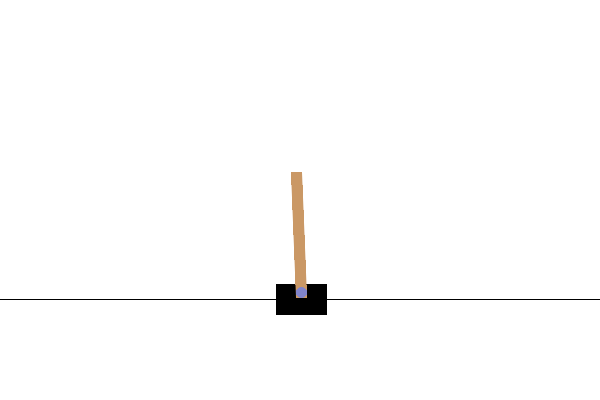

In [ ]:
render_video(cartPoleDefault, DQN_agent_default)

On fait de même pour l'agent modifié.

In [ ]:
DQN_agent_modified = DQN(cartPoleModified.observation_space, cartPoleModified.action_space)
episode_rewards_DQN_modified, losses_DQN_modified, vals_DQN_modified = training_DQN(DQN_agent_modified, cartPoleModified, NUM_STEPS, LOG_FREQUENCY)

100%|██████████| 50000/50000 [00:45<00:00, 1087.09it/s]


In [ ]:
mean_return, std_return = evaluate_agent(DQN_agent_modified, cartPoleModified, num_episodes=50)
print(f"\nReturns : {mean_return} ± {std_return}")

100%|██████████| 50/50 [00:03<00:00, 12.98it/s]


Returns : 305.16 ± 83.75568279227387


Return:  222.0


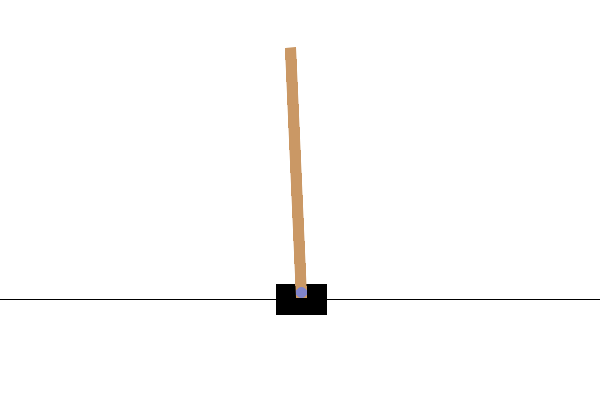

In [ ]:
render_video(cartPoleModified, DQN_agent_modified)

On affiche les résultats d'entrainements sur les récompenses.

In [ ]:
def smooth(array, n_running_average=10):
    return np.convolve(np.array(array), np.ones(n_running_average)/n_running_average, mode="full")[:-(n_running_average-1)]

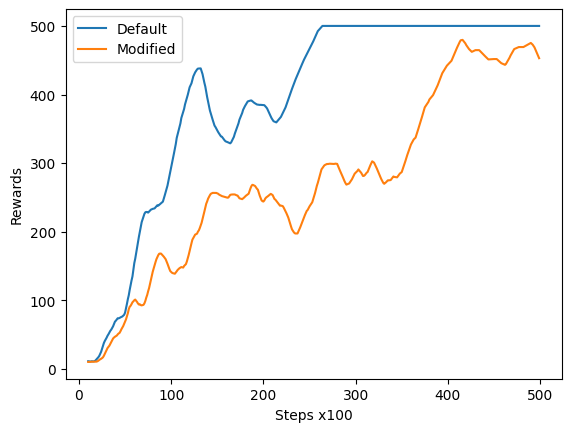

In [ ]:
plt.plot(smooth(episode_rewards_DQN_default), label='Default')
plt.plot(smooth(episode_rewards_DQN_modified), label='Modified')
plt.ylabel("Rewards")
plt.xlabel("Steps x100")
plt.legend()

En analysant le graphique des récompenses, il est apparent que l'apprentissage de l'environnement par défaut est plus rapide celui de l'environnement modifié, avec l'utilisation des mêmes paramètres d'entraînement. Cependant, après 50 000 étapes, l'algorithme DQN démontre des performances satisfaisantes pour les deux environnements. Il est à noter que l'agent par défaut semble être bien entraîné dès les 25 000 premières étapes, suggérant que sa politique constitue une base solide pour l'apprentissage par Tranfer Learning ultérieur.

#### **VI.1.2 - REINFORCE avec baseline**

On entraine l'agent par défaut avec REINFORCE et on visualise le résultat.

In [ ]:
REINFORCE_agent_default = REINFORCEWithBaselinePolicy(cartPoleDefault, policy_init_network(cartPoleDefault), value_init_network(cartPoleDefault))
episode_rewards_REINFORCE_default, losses_REINFORCE_default, vals_REINFORCE_default = training_REINFORCE(REINFORCE_agent_default, cartPoleDefault, gradient_steps, test_runs)

Training REINFORCE with Baseline


100%|██████████| 500/500 [08:09<00:00,  1.02it/s]


In [ ]:
mean_return, std_return = evaluate_agent(REINFORCE_agent_default, cartPoleDefault, num_episodes=50)
print(f"\nReturns : {mean_return} ± {std_return}")

100%|██████████| 50/50 [00:13<00:00,  3.78it/s]


Returns : 455.12 ± 61.691373789209784


Return:  500.0


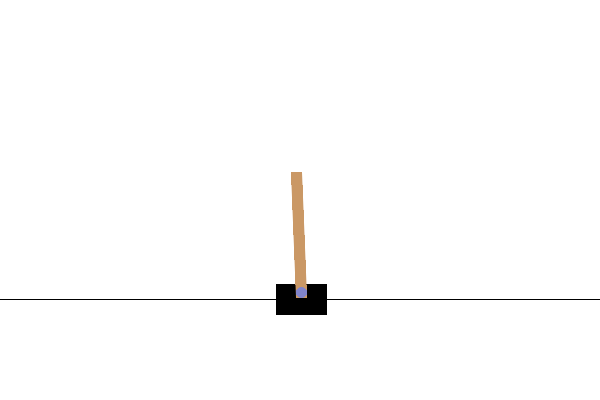

In [ ]:
render_video(cartPoleDefault, REINFORCE_agent_default)

On fait de même pour l'agent modifié.

In [ ]:
REINFORCE_agent_modified = REINFORCEWithBaselinePolicy(cartPoleModified, policy_init_network(cartPoleModified), value_init_network(cartPoleModified))
episode_rewards_REINFORCE_modified, losses_REINFORCE_modified, vals_REINFORCE_modified = training_REINFORCE(REINFORCE_agent_modified, cartPoleModified, gradient_steps, test_runs)

Training REINFORCE with Baseline


100%|██████████| 500/500 [01:16<00:00,  6.53it/s]


In [ ]:
mean_return, std_return = evaluate_agent(REINFORCE_agent_modified, cartPoleModified, num_episodes=50)
print(f"\nReturns : {mean_return} ± {std_return}")

100%|██████████| 50/50 [00:00<00:00, 52.58it/s]


Returns : 33.4 ± 11.934822998268555


Return:  53.0


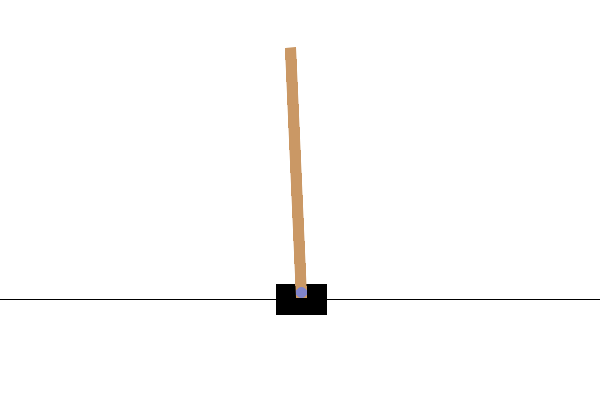

In [ ]:
render_video(cartPoleModified, REINFORCE_agent_modified)

On affiche les résultats d'entrainements sur les récompenses.

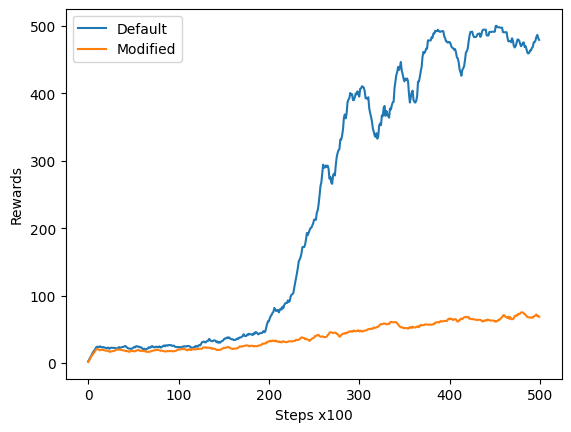

In [ ]:
plt.plot(smooth(episode_rewards_REINFORCE_default), label='Default')
plt.plot(smooth(episode_rewards_REINFORCE_modified), label='Modified')
plt.ylabel("Rewards")
plt.xlabel("Steps x100")
plt.legend()

Pour le REINFORCE avec baseline, les résultats diffèrent de ceux obtenus avec l'agent DQN. Après 50 000 étapes, l'analyse du graphique des récompenses et de la visualisation des environnements révèle que l'environnement par défaut présente des performances satisfaisantes. En revanche, les performances de l'environnement modifié sont nettement plus faibles, la récompense n'excédant pas 100 avec l'utilisation des mêmes paramètres d'entraînement.

De la même manière, la politique de l'environnement par défaut se révèle être une base robuste pour l'apprentissage ultérieur par transfert. Cela permettra une comparaison facile des performances entre les deux environnements modifié et par défaut.

Il est à noter que le temps d'entraînement avec le REINFORCE avec baseline est relativement plus élevé.

### **VI.2 - Entrainements avec Transfer Learning**



Pour le transfert d'apprentissage, nous entraînons le modèle CartPole modifié en initialisant ses paramètres avec la politique du modèle CartPole par défaut. Ensuite, nous évaluons la vitesse et la qualité de l'apprentissage du modèle CartPole modifié par rapport à un entraînement sans transfert d'apprentissage.

Concernant le transfert de politique, la procédure est la suivante :
- Pour l'agent Deep Q-Network, nous transférons les poids du réseau de neurones définissant l'agent CartPole par défaut (sans transfert d'apprentissage) vers le nouvel agent créé pour l'entraînement du CartPole modifié avec transfert d'apprentissage.
- Pour l'agent REINFORCE avec baseline, deux réseaux de neurones définissent l'agent, à savoir la politique et la valeur de référence (baseline). Ainsi, nous créons trois agents pour le transfert d'apprentissage :
  1. Un premier agent en copiant à la fois la politique et la fonction de valeur.
  2. Un deuxième agent en copiant uniquement la politique.
  3. Un troisième agent en copiant uniquement la fonction de valeur.

#### **VI.2.1 - Deep Q-Network (DQN)**

In [ ]:
# Create a new agent.
DQN_agent_mod_with_transfer = DQN(cartPoleModified.observation_space, cartPoleModified.action_space)
# Copy the policy of the default agent.
DQN_agent_mod_with_transfer.network.load_state_dict(DQN_agent_default.network.state_dict())
# Train the agent on the modified environnement with TL.
episode_rewards_DQN_mod_with_transfer, losses_DQN_mod_with_transfer, vals_DQN_mod_with_transfer = training_DQN(DQN_agent_mod_with_transfer, cartPoleModified, NUM_STEPS, LOG_FREQUENCY)

100%|██████████| 50000/50000 [00:43<00:00, 1145.22it/s]


#### **VI.2.2 - REINFORCE avec baseline**

In [ ]:
import copy

# Create a new agent with TL for policy + value.
policy_network_copy1 = copy.deepcopy(REINFORCE_agent_default.network)
value_network_copy1 = copy.deepcopy(REINFORCE_agent_default.value_network)
REINFORCE_agent_mod_with_transfer_all = REINFORCEWithBaselinePolicy(cartPoleModified, policy_network_copy1, value_network_copy1)

# Create a new agent with TL for policy.
policy_network_copy2 = copy.deepcopy(REINFORCE_agent_default.network)
value_network = value_init_network(cartPoleDefault)
REINFORCE_agent_mod_with_transfer_policy = REINFORCEWithBaselinePolicy(cartPoleModified, policy_network_copy2, value_network)

# Create a new agent with TL for value.
policy_network = policy_init_network(cartPoleDefault)
value_network_copy2 = copy.deepcopy(REINFORCE_agent_default.value_network)
REINFORCE_agent_mod_with_transfer_value = REINFORCEWithBaselinePolicy(cartPoleModified, policy_network, value_network_copy2)


In [ ]:
# Create a new agent with TL for policy + value.
REINFORCE_agent_mod_with_transfer_all = REINFORCEWithBaselinePolicy(cartPoleModified, REINFORCE_agent_default.network, REINFORCE_agent_default.value_network)
# Create a new agent with TL for policy.
REINFORCE_agent_mod_with_transfer_policy = REINFORCEWithBaselinePolicy(cartPoleModified, REINFORCE_agent_default.network, value_init_network(cartPoleDefault))
# Create a new agent with TL for value.
REINFORCE_agent_mod_with_transfer_value = REINFORCEWithBaselinePolicy(cartPoleModified, policy_init_network(cartPoleDefault), REINFORCE_agent_default.value_network)

# Train the agent on the modified environnement with TL.
episode_rewards_REINFORCE_mod_with_transfer_all, losses_REINFORCE_mod_with_transfer_all, vals_REINFORCE_mod_with_transfer_all = training_REINFORCE(REINFORCE_agent_mod_with_transfer_all, cartPoleModified, gradient_steps, test_runs)
episode_rewards_REINFORCE_mod_with_transfer_policy, losses_REINFORCE_mod_with_transfer_policy, vals_REINFORCE_mod_with_transfer_policy = training_REINFORCE(REINFORCE_agent_mod_with_transfer_policy, cartPoleModified, gradient_steps, test_runs)
episode_rewards_REINFORCE_mod_with_transfer_value, losses_REINFORCE_mod_with_transfer_value, vals_REINFORCE_mod_with_transfer_value = training_REINFORCE(REINFORCE_agent_mod_with_transfer_value, cartPoleModified, gradient_steps, test_runs)

Training REINFORCE with Baseline


100%|██████████| 500/500 [08:19<00:00,  1.00it/s]


Training REINFORCE with Baseline


100%|██████████| 500/500 [11:02<00:00,  1.33s/it]


Training REINFORCE with Baseline


100%|██████████| 500/500 [01:06<00:00,  7.57it/s]


### **VI.3 - Comparaison des résultats**

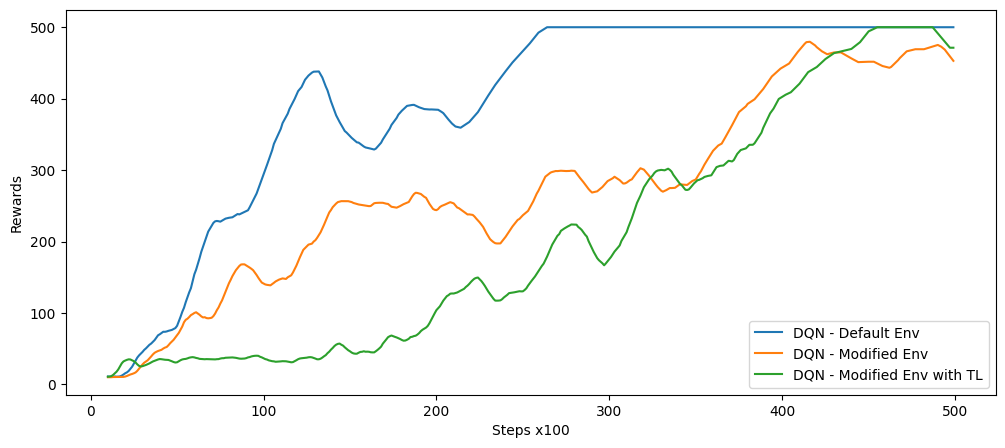

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(smooth(episode_rewards_DQN_default), label='DQN - Default Env')
plt.plot(smooth(episode_rewards_DQN_modified), label='DQN - Modified Env')
plt.plot(smooth(episode_rewards_DQN_mod_with_transfer), label='DQN - Modified Env with TL')
plt.ylabel("Rewards")
plt.xlabel("Steps x100")
plt.legend()

On remarque que le transfert learning avec DQN n'est pas très efficace. En effet, lorsque on compare l'entrainement de l'environnement modifié avec et sans transfer learning, les différences sont similaires voir pire avec le transfer learning. Dans ce cas, le transfer learning n'a pas d'avantage.

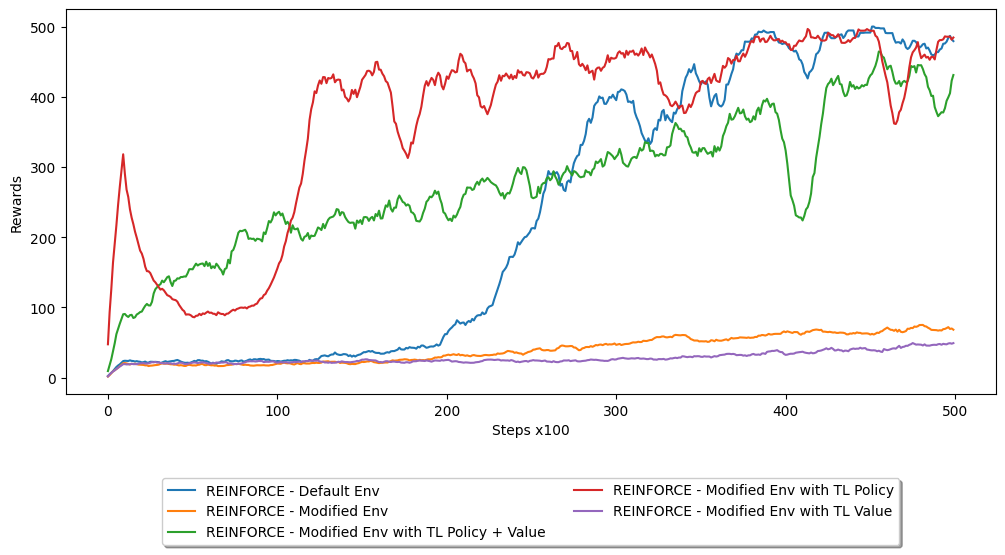

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(smooth(episode_rewards_REINFORCE_default), label='REINFORCE - Default Env')
plt.plot(smooth(episode_rewards_REINFORCE_modified), label='REINFORCE - Modified Env')
plt.plot(smooth(episode_rewards_REINFORCE_mod_with_transfer_all), label='REINFORCE - Modified Env with TL Policy + Value')
plt.plot(smooth(episode_rewards_REINFORCE_mod_with_transfer_policy), label='REINFORCE - Modified Env with TL Policy')
plt.plot(smooth(episode_rewards_REINFORCE_mod_with_transfer_value), label='REINFORCE - Modified Env with TL Value')
plt.ylabel("Rewards")
plt.xlabel("Steps x100")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=True, shadow=True, ncol=2)

En revanche, avec l'algorithme REINFORCE, les résultats sont différents. Le Tranfer Learning par transfert de politique montre son efficacité ici. **Les meilleures résultats sont obtenus en copiant uniquement la politique de l'environnement par défaut.** Le tranfert de politique fonctionne également lorsqu'on copie la politique et la fonction de valeur. A 20,000 steps, toutes les entrainements sans transfert learning sont proches de la récompenses nulles et n'ont pas evolué tandis que les courbes représentant un entrainement par tranfert de politique sont déjà à 250 et 450 de récompenses. Une copie de la fonction de valeur uniquement change que très peu les résultats.

L'algorithme REINFORCE produit des résultats différents qu'avec DQN. L'efficacité du Transfer Learning par transfert de politique se manifeste clairement dans ce contexte. **Les performances optimales sont observées lorsqu'on copie exclusivement la politique de l'environnement par défaut.** Le transfert de politique demeure également efficace lorsqu'on reproduit à la fois la politique et la fonction de valeur. **Après 20 000 étapes, les entraînements sans Tranfer Learning stagnent autour de récompenses nulles, n'affichant aucune évolution, tandis que les courbes représentant un entraînement par transfert de politique atteignent déjà des récompenses de 250 et 450.** La copie exclusive de la fonction de valeur entraîne des changements minimes dans les résultats.

Ainsi, ces exemples soulignent que l'efficacité de la technique de transfert de politique dépend de l'algorithme utilisé. Dans ce contexte, cette approche se révèle performante avec l'algorithme REINFORCE, mais moins avec DQN. Les résultats les plus probants en matière de transfert de politique sont obtenus par la simple copie de la politique, spécifiquement avec l'algorithme REINFORCE avec baseline. **Le Tranfer Learning permet d'accélérer considérablement l'apprentissage au début de l'entrainement.**

Voici quelques idées pour des futures études:
- Évaluer différents algorithmes et stratégies de Tranfer Learning.
- Envisager le transfert des politiques vers des environnements autres que CartPole.
- Effectuer des test en ajustant les paramètres d'apprentissage des algorithmes, tels que le learning rate, etc.

## **VII - Bibliographie**

[1] George Karimpanal T, Bouffanais R (2018). Self-organizing maps for storage and transfer of knowledge in reinforcement learning. Adaptive Behavior. 2019;27(2):111-126.doi:10.1177/1059712318818568.

[2] Emilio Parisotto, Jimmy Ba, Ruslan Salakhutdinov (2016), Actor-Mimic Deep Multitask and Transfer Reinforcement Learning

[3] Jonathan Hui (Apr 18, 2022). RL - Transfer Learning. Medium [Online]. Available : https://jonathan-hui.medium.com/

[4] Sergey Levine (2017). CS 294-112: Deep Reinforcement Learning, Transfer Learning, Lecture 14. US Berkeley EECS [Online]. Available : https://rail.eecs.berkeley.edu/deeprlcourse-fa17

[5] Alessandro Lazaric (2012). Transfer in Reinforcement Learning: A Framework and a Survey

[6] Owain Biddulph (Nov 30, 2021). Le transfert learning en pratique - étapes clés et exemples de code
[Online]. Available : https://medium.com/neoxia/le-transfer-learning-en-pratique-%C3%A9tapes-cl%C3%A9s-et-exemples-de-code-cfd76c0a8a42

[7] Tahir Mehmood, Alfonso E. Gerevini, Alberto Lavelli, Ivan Serina (2020). Combining Multi-task Learning with Transfer Learning for Biomedical Named Entity Recognition
[Online]. Available : https://www.sciencedirect.com/science/article/pii/S1877050920319785

[8] Zhuangdi Zhu, Kaixiang Lin, Anil K. Jain, Jiayu Zhou (Jul 4 2023). Transfer Learning in Deep Reinforcement Learning : A Survey
[Online]. Available : https://arxiv.org/pdf/2009.07888.pdf
